In [150]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..'))
if not dir1 in sys.path: sys.path.append(dir1)
from utils.environment import setup_data_vars
setup_data_vars()

In [151]:
support_size = 80

In [152]:
from torch.utils.data import Dataset
import random
import math
import numpy as np
import cv2
import torch

class UniverSegDataSet(Dataset):
    def __init__(self, support_size, training=True):

        self.medsam_gts = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts')
        self.medsam_imgs = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')

        self.support_size = support_size

        self.training = training
        self.anatomies = dict([(f, dict()) for f in os.listdir(self.medsam_gts) if f != 'TotalBinary'])

        min_samples = float('inf')

        for anatomy in self.anatomies.keys():
            for axis in [f for f in os.listdir(os.path.join(self.medsam_gts, anatomy)) if 'axis' in f]:
                subdir = os.path.join(anatomy, axis)

                samples = [f for f in os.listdir(os.path.join(self.medsam_gts, subdir)) if f.endswith('.npy')]
                random.shuffle(samples)

                if len(samples) < min_samples:
                    min_samples = len(samples)

                self.anatomies[anatomy][axis] = samples

        self.anatomy_keys = sorted(list(self.anatomies.keys()))
        self.list_of_axis = sorted(list(self.anatomies[self.anatomy_keys[0]].keys()))

        self.setup_sampler()

        self.training_length = min_samples * len(self.anatomy_keys) * len(self.list_of_axis)

    def set_training(self):
        self.training = True
        self.setup_sampler()

    def set_validation(self):
        self.training = False
        self.setup_sampler()

    def __len__(self):
        return self.training_length
    
    def setup_sampler(self):
        if self.training:
            self._sample_to_consider = lambda idx: (idx // (len(self.list_of_axis) * len(self.anatomy_keys)))
        else:
            self._sample_to_consider = lambda idx: -(idx // (len(self.list_of_axis) * len(self.anatomy_keys))) - 1

    def _read_image_and_gt(self, img_id, img_slice, anatomy, axis):
        img = np.load(os.path.join(self.medsam_imgs, f'axis{axis}', f'CT_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        gt = np.load(os.path.join(self.medsam_gts, anatomy, f'axis{axis}', f'CT_{anatomy}_zzAMLART_{img_id:03d}-{img_slice:03d}.npy'))
        return img, gt

    def _anatomy_to_consider(self, idx):
        return self.anatomy_keys[(idx // len(self.list_of_axis)) % len(self.anatomy_keys)]
    
    def _axis_to_consider(self, idx):
        return self.list_of_axis[idx % len(self.list_of_axis)]
    
    def __getitem__(self, idx):
        anatomy_to_consider = self._anatomy_to_consider(idx)
        axis_to_consider = self._axis_to_consider(idx)
        sample_to_consider = self._sample_to_consider(idx)

        ith_example = self.anatomies[anatomy_to_consider][axis_to_consider][sample_to_consider]

        get_id_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[0])
        get_slice_from_img = lambda img_name: int(img_name.split('_')[3].split('-')[1].split('.')[0])

        ith_id = get_id_from_img(ith_example)
        ith_slice = get_slice_from_img(ith_example)

        # get a support set that doesn't contain the same id as the ith example
        support_set = random.sample([f for f in self.anatomies[anatomy_to_consider][axis_to_consider] if get_id_from_img(f) != ith_id], self.support_size)

        # read in the images and gts for the ith example and the support set and resize them appropriately
        ith_img, ith_gt = self._read_image_and_gt(ith_id, ith_slice, anatomy_to_consider, int(axis_to_consider[-1]))

        support_imgs = []
        support_gts = []

        for support_example in support_set:
            support_img, support_gt = self._read_image_and_gt(get_id_from_img(support_example), get_slice_from_img(support_example), anatomy_to_consider, int(axis_to_consider[-1]))

            support_imgs.append(support_img)
            support_gts.append(support_gt)

        # resize the images and gts to 128x128 we need for universeg

        ith_img = cv2.resize(ith_img, (128, 128), interpolation=cv2.INTER_LINEAR)
        ith_gt = cv2.resize(ith_gt, (128, 128), interpolation=cv2.INTER_NEAREST)

        support_imgs = [cv2.resize(support_img, (128, 128), interpolation=cv2.INTER_LINEAR) for support_img in support_imgs]
        support_gts = [cv2.resize(support_gt, (128, 128), interpolation=cv2.INTER_NEAREST) for support_gt in support_gts]

        # convert to torch tensors

        ith_img = torch.from_numpy(ith_img).float().unsqueeze(0)
        ith_gt = torch.from_numpy(ith_gt).float().unsqueeze(0)

        support_imgs = [torch.from_numpy(support_img).float().unsqueeze(0) for support_img in support_imgs]
        support_gts = [torch.from_numpy(support_gt).float().unsqueeze(0) for support_gt in support_gts]

        # stack the support images and gts
        support_imgs = torch.stack(support_imgs) # (S x 128 x 128)
        support_gts = torch.stack(support_gts) # (S x 128 x 128)

        assert support_imgs.shape == (self.support_size, 1, 128, 128), support_imgs.shape
        assert support_gts.shape == (self.support_size, 1, 128, 128), support_gts.shape
        assert ith_img.shape == (1, 128, 128), ith_img.shape
        assert ith_gt.shape == (1, 128, 128), ith_gt.shape

        return {
            'query_name': ith_example,
            'query_anatomy_axis': f'{anatomy_to_consider}_{axis_to_consider}', 
            'query': ith_img,
            'query_gt': ith_gt,
            'support_name': support_set,
            'support_imgs': support_imgs,
            'support_gts': support_gts
        }

In [153]:
from torch.utils.data import DataLoader


my_dataset = UniverSegDataSet(support_size=support_size)
my_dataloder = DataLoader(my_dataset, batch_size=1, shuffle=True)

# get a batch of data

for i, batch in enumerate(my_dataloder):
    print(batch['query'].shape)
    print(batch['query_gt'].shape)
    print(batch['support_imgs'].shape)
    print(batch['support_gts'].shape)
    break

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 80, 1, 128, 128])
torch.Size([1, 80, 1, 128, 128])


In [154]:
from platipy.imaging.label.comparison import compute_metric_total_apl, compute_surface_dsc, compute_metric_hd
import SimpleITK as sitk
from universeg import universeg

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

# Run the inference
model_ootb = universeg(pretrained=True)
model_ootb = model_ootb.to(device)

model_finetuned = universeg(pretrained=False)
model_finetuned = model_finetuned.to(device)

# load in parameters from the trained model
checkpoint = torch.load(os.path.join(os.environ.get('PROJECT_DIR'), 'research/source/code/UniverSeg/results_finetuned/finetuning/model_checkpoint_best.pth'))

model_finetuned.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [156]:
def predict_with_model(batch, model):
    image = batch['query'].to(device)
    support_images = batch['support_imgs'].to(device)
    support_labels = batch['support_gts'].to(device)
    
    image = image.to(device)
    # label = label.to(device)
    support_images = support_images.to(device)
    support_labels = support_labels.to(device)

    prediction_logits = model(image, support_images, support_labels)
    prediction_soft = torch.sigmoid(prediction_logits)

    # threshold probabilities to get hard predictions
    prediction_hard = (prediction_soft > 0.5).float()

    return prediction_hard

In [157]:
def get_dice(prediction, ground_truth):
    prediction = prediction.cpu().detach().numpy().astype(np.uint8)[0]
    ground_truth = ground_truth.cpu().detach().numpy().astype(np.uint8)[0]

    prediction = sitk.GetImageFromArray(prediction)
    label_sitk = sitk.GetImageFromArray(ground_truth)

    overlap_measures_filter.Execute(label_sitk, prediction)

    return overlap_measures_filter.GetDiceCoefficient()

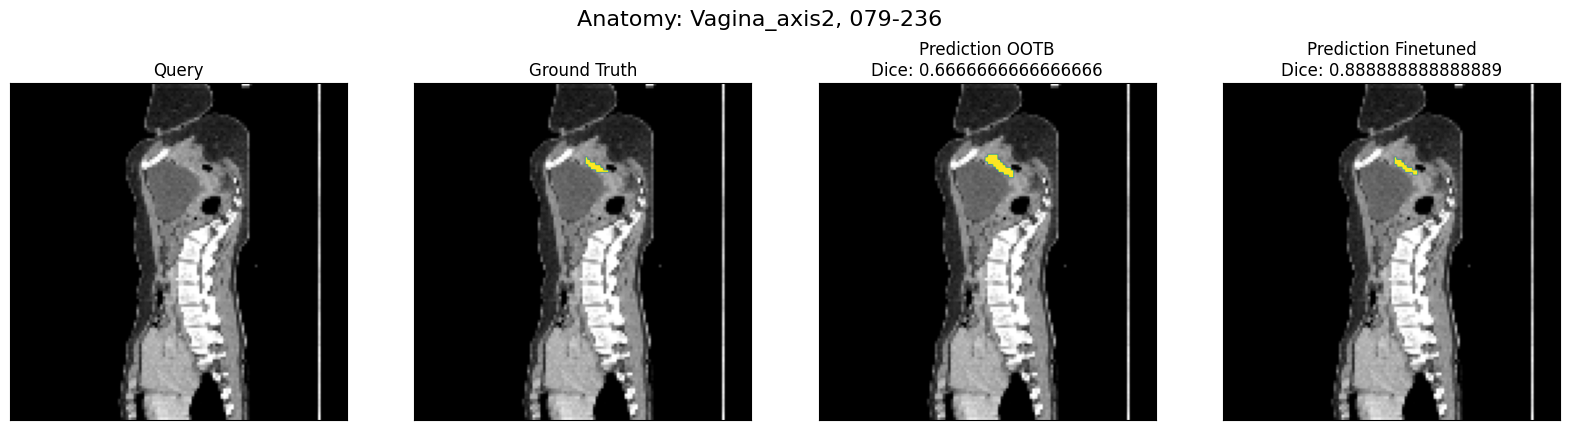

In [158]:
import matplotlib.pyplot as plt

prediction_ootb = predict_with_model(batch, model_ootb)
prediction_finetuned = predict_with_model(batch, model_finetuned)

ncols = 4
nrows = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

for i in range(ncols):
    axs[i].imshow(batch['query'].squeeze().cpu().numpy(), cmap='gray')
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)

axs[0].set_title('Query')

axs[1].imshow(batch['query_gt'].squeeze().cpu().numpy(), cmap='viridis', alpha=(batch['query_gt'].squeeze().cpu().numpy() > 0).astype(np.float32))
axs[1].set_title(f'Ground Truth')

axs[2].imshow(prediction_ootb.squeeze().cpu().numpy(), cmap='viridis', alpha=(prediction_ootb.squeeze().cpu().numpy() > 0).astype(np.float32))
axs[2].set_title(f'Prediction OOTB\nDice: {get_dice(prediction_ootb, batch["query_gt"])}')

axs[3].imshow(prediction_finetuned.squeeze().cpu().numpy(), cmap='viridis', alpha=(prediction_finetuned.squeeze().cpu().numpy() > 0).astype(np.float32))
axs[3].set_title(f'Prediction Finetuned\nDice: {get_dice(prediction_finetuned, batch["query_gt"])}')

plt.suptitle(f'Anatomy: {batch["query_anatomy_axis"][0]}, {batch["query_name"][0].split("_")[-1].split(".")[0]}', fontsize=16)
plt.show()

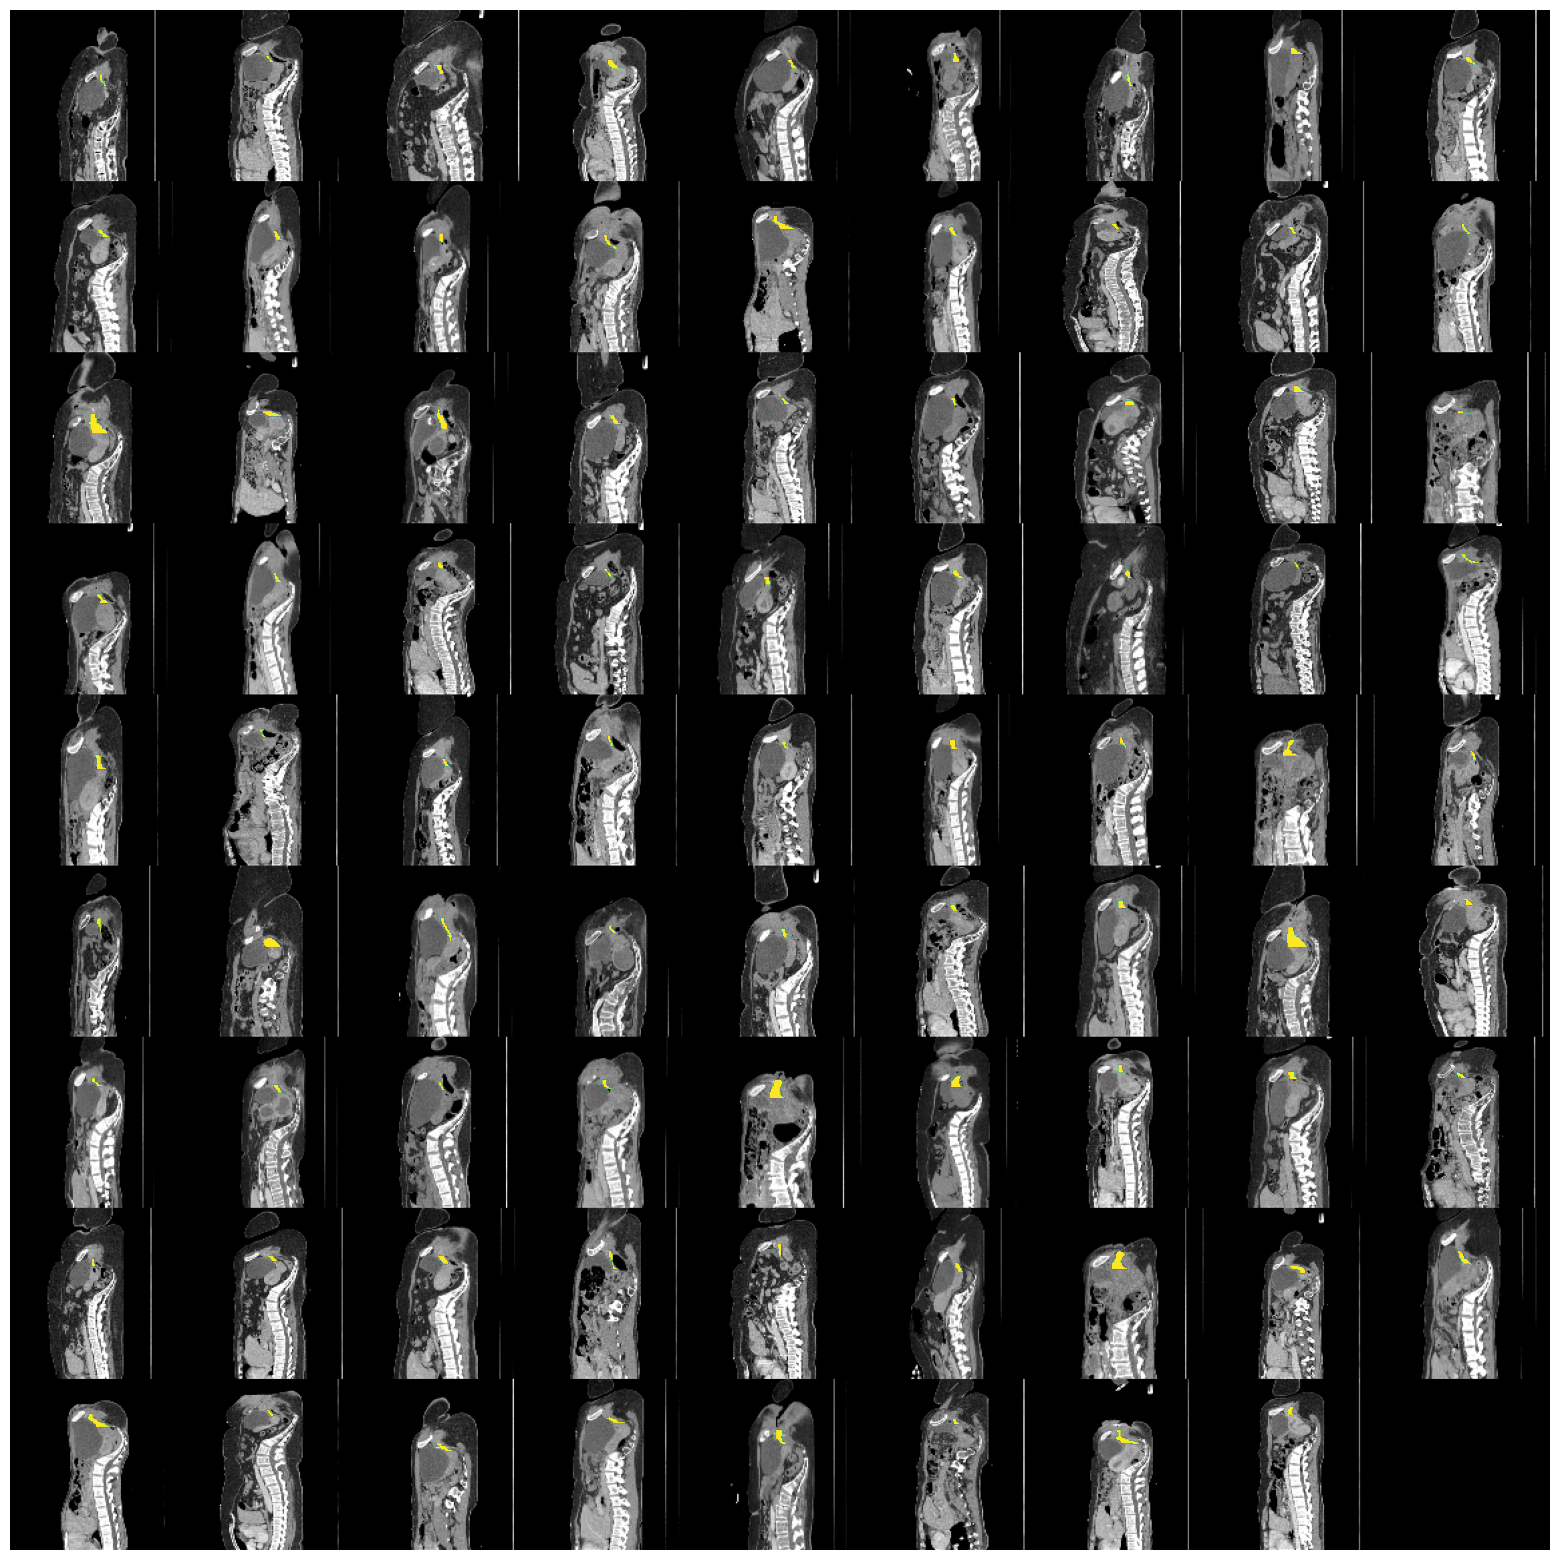

In [159]:
# print the support

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

support_imgs = batch['support_imgs'].float()[0]
support_gts = batch['support_gts'].float()[0]

grid_imgs = make_grid(support_imgs, nrow=9, padding=0, normalize=True).permute(1, 2, 0).numpy()
grid_gts = make_grid(support_gts, nrow=9, padding=0, normalize=True).permute(1, 2, 0).numpy()

grid_gts = np.sum(grid_gts, axis=2) / 3

plt.figure(figsize=(20, 20))
plt.imshow(grid_imgs, cmap='gray')
plt.imshow(grid_gts, alpha=grid_gts, cmap='viridis')

plt.axis('off')
plt.show()